Linear regression is somewhat trivial and is basically linear algebra with some regualator maybe and some good feature model etc. We will instead look at what ML can give us. Regression should hopefully be the most basic of all the ML-model, since we have some data and target and want to minimize L2-norm (if error is Guassian).   

In [1]:
import tensorflow as tf
import numpy as np
from tensorflow import keras

We will look (as usual) at the mnist dataset.

In [2]:
# MNIST dataset parameters.
num_classes = 10 # 0 to 9 digits
num_features = 784 # 28*28

# Training parameters.
learning_rate = 0.01
training_steps = 1000
batch_size = 256
display_step = 50

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Convert to float32.
x_train, x_test = np.array(x_train, np.float32), np.array(x_test, np.float32)
# Flatten images to 1-D vector of 784 features (28*28).
x_train, x_test = x_train.reshape([-1, num_features]), x_test.reshape([-1, num_features])
# Normalize images value from [0, 255] to [0, 1].
x_train, x_test = x_train / 255., x_test / 255.

In [3]:
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.repeat().shuffle(5000).batch(batch_size).prefetch(1)

In [4]:
class logits_layer(keras.layers.Layer):
    def __init__(self,units=num_classes):
        super(logits_layer, self).__init__()
        self.units = units

    def build(self, input_shape):
        self.W = self.add_weight(
            shape=(input_shape[-1], self.units),
            initializer="random_normal",
            trainable=True,
        )
        self.b = self.add_weight(
            shape=(self.units,), initializer="random_normal", trainable=True
        )

    def call(self, inputs): 
        x = tf.matmul(inputs, self.W) + self.b
        return tf.exp(x) / tf.reduce_sum(tf.exp(x))

class logits_model(keras.Model):
    def __init__(self):
        super(logits_model, self).__init__()
        self.block_1 = logits_layer()

    def call(self, inputs):
        return self.block_1(inputs)

In [5]:
optimizer = tf.optimizers.SGD(learning_rate)
epochs = 10
loss_history = []

model = logits_model()


for epoch in range(epochs):
    for image, label in train_data.take(training_steps):
        with tf.GradientTape() as tape:
            y_pred = model(image)
            y_true  = tf.one_hot(label, depth=num_classes)
            y_pred  = tf.clip_by_value(y_pred, 1e-9, 1.)
            loss = tf.reduce_mean(-tf.reduce_sum(y_true * tf.math.log(y_pred),1))
            
        loss_history.append(loss.numpy())
        varib = model.trainable_variables
        gradients = tape.gradient(loss, varib)
        optimizer.apply_gradients(zip(gradients, varib))

In [6]:
def accuracy(y_pred, y_true):
    # Predicted class is the index of highest score in prediction vector (i.e. argmax).
    correct_prediction = tf.equal(tf.argmax(y_pred, 1), tf.cast(y_true, tf.int64))
    return tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

pred = model(x_test)
print("Test Accuracy: %f" % accuracy(pred, y_test))

Test Accuracy: 0.905500


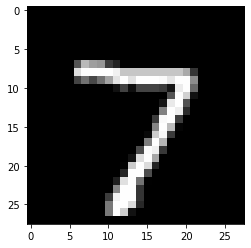

Model prediction: 7


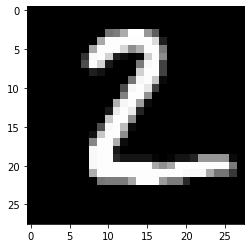

Model prediction: 2


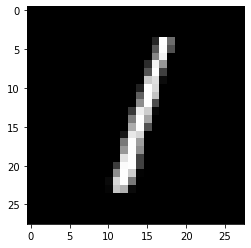

Model prediction: 1


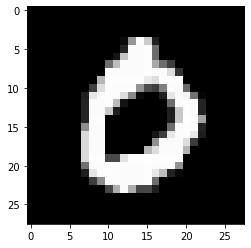

Model prediction: 0


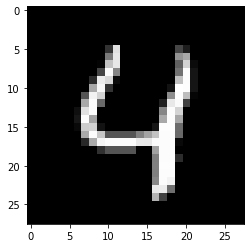

Model prediction: 4


In [7]:
import matplotlib.pyplot as plt

n_images = 5
test_images = x_test[:n_images]
predictions = model(test_images)

# Display image and model prediction.
for i in range(n_images):
    plt.imshow(np.reshape(test_images[i], [28, 28]), cmap='gray')
    plt.show()
    print("Model prediction: %i" % np.argmax(predictions.numpy()[i]))

Text(0, 0.5, 'Loss [entropy]')

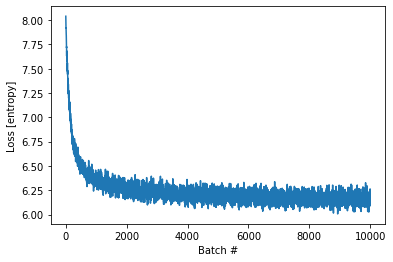

In [8]:
plt.plot(loss_history)
plt.xlabel('Batch #')
plt.ylabel('Loss [entropy]')

We could have used the keras API, but went through the "lower level" to have a logistic regression with cross entropy as loss function. We will now go through standard regression workflow with a more interesting dataset. 

In [9]:
!pip install -q seaborn

In [10]:
import pathlib
import pandas as pd
import seaborn as sns

In [11]:
dataset_path = keras.utils.get_file("auto-mpg.data", "http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data")


32768/30286 [================================] - 0s 5us/step


In [12]:
column_names = ['MPG','Cylinders','Displacement','Horsepower','Weight',
                'Acceleration', 'Model Year', 'Origin']
dataset = pd.read_csv(dataset_path, names=column_names,
                      na_values = "?", comment='\t',
                      sep=" ", skipinitialspace=True)

dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


This dataset contains features of late-1970s and early 1980s automobiles to predict fuel efficiency. We first have to clean up the dataset.

In [18]:
print(dataset.isna().sum())
dataset = dataset.dropna()

#Change so Origin get its own column.
dataset['Origin'] = dataset['Origin'].map({1: 'USA', 2: 'Europe', 3: 'Japan'})
dataset = pd.get_dummies(dataset, prefix='', prefix_sep='')
dataset.tail()

MPG             0
Cylinders       0
Displacement    0
Horsepower      0
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64


,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Europe,Japan,USA
393,27.0,4,140.0,86.0,2790.0,15.6,82,0,0,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,1,0,0
395,32.0,4,135.0,84.0,2295.0,11.6,82,0,0,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,0,0,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,0,0,1


In [19]:
train_dataset = dataset.sample(frac=0.8,random_state=0)
test_dataset = dataset.drop(train_dataset.index)

,count,mean,std,min,25%,50%,75%,max
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0
Europe,314.0,0.178344,0.383413,0.0,0.00,0.0,0.00,1.0
Japan,314.0,0.197452,0.398712,0.0,0.00,0.0,0.00,1.0
USA,314.0,0.624204,0.485101,0.0,0.00,1.0,1.00,1.0


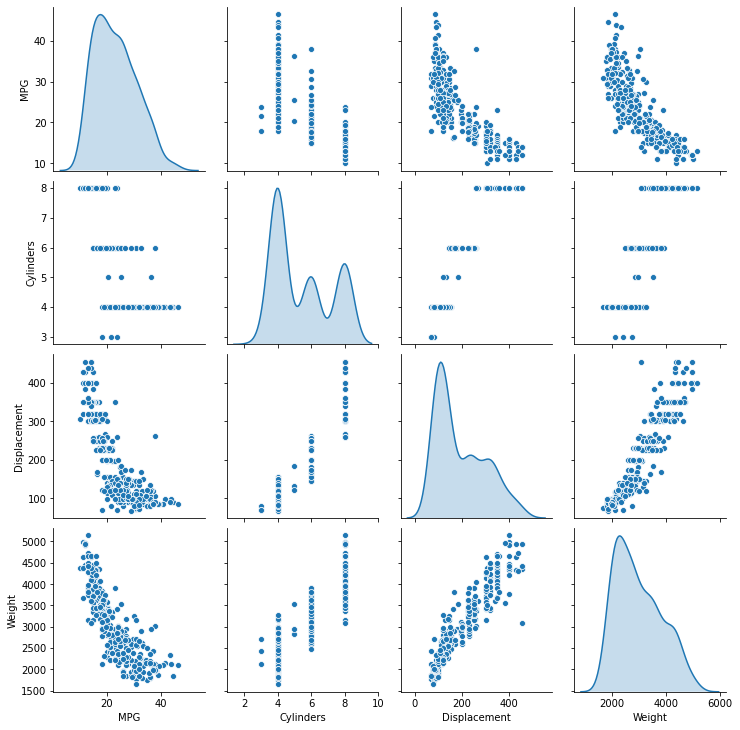

In [21]:
#Distributions
sns.pairplot(train_dataset[["MPG", "Cylinders", "Displacement", "Weight"]], diag_kind="kde")

#Dataset statistics
train_stats = train_dataset.describe()
train_stats.pop("MPG")
train_stats = train_stats.transpose()
train_stats

In [22]:
train_labels = train_dataset.pop('MPG')
test_labels = test_dataset.pop('MPG')

In [23]:
def norm(x):
  return (x - train_stats['mean']) / train_stats['std']
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

Let's make two densely connected hidden layers, and an output layer that returns the predicted fuel efficiency.

In [26]:
def build_model():
  model = keras.Sequential([
    keras.layers.Dense(64, activation='relu', input_shape=[len(train_dataset.keys())]),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

In [27]:
model = build_model()

In [28]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                640       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 4,865
Trainable params: 4,865
Non-trainable params: 0
_________________________________________________________________


In [30]:
EPOCHS = 1000

history = model.fit(
  normed_train_data, train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=0)

Let's see the training process.

In [31]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
995,2.153663,0.906324,2.153663,7.140876,2.009184,7.140876,995
996,2.379412,1.005674,2.379412,7.414423,2.059644,7.414423,996
997,2.399502,0.975151,2.399502,7.292453,2.045841,7.292453,997
998,2.276631,0.965436,2.276631,7.515330,2.061369,7.515330,998
999,2.306686,0.951654,2.306686,7.649133,2.130877,7.649133,999


In [32]:
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=2)

print("Testing set Mean Abs Error: {:5.2f} MPG".format(mae))

3/3 - 0s - loss: 7.2676 - mae: 2.1068 - mse: 7.2676
Testing set Mean Abs Error:  2.11 MPG


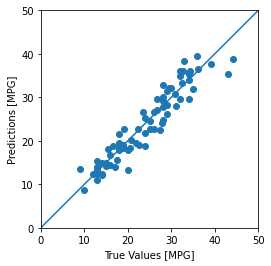

In [33]:
test_predictions = model.predict(normed_test_data).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
lims = [0, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

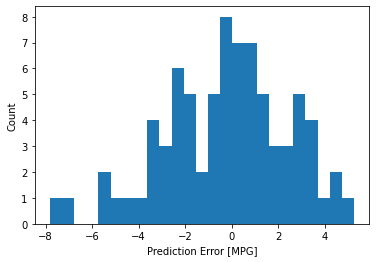

In [34]:
error = test_predictions - test_labels
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [MPG]")
_ = plt.ylabel("Count")